# Featurization

This notebook is intended to featurize the data associated with CRISPRi activity scores to make it easier to train a linear regression model to.

The data used is that from the following paper:

[Compact and highly active next-generation libraries for CRISPR-mediated gene repression and activation](https://elifesciences.org/articles/19760)

__Authors__: Anthony Hein, Briana Macedo, Manya Kapoor

---

###  _TODO: Create similar contribution graph_
### _TODO:  Z-standardize all numerical data__


__Bold == Featurized!__

Features available from data:
- Distance to TSS (primary and secondary, downstream and upstream)
- __sgRNA length__
- __(+) or (-) stranded sgRNA__
- __Longest consecutive run of each base__
- __Overall nucleotide composition (% of A, C, T, G, GC, CA, AG)__
- __Nucleotides at each position__
- __Nucleotides dimers at each position__

Features unavailable (stretch goal):
- DNAse-seq signal
- MNase-seq signal
- FAIRE-seq signal
- sgRNA overall folding free energy
- RNA pairing at each position





In [23]:
### IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
### READ DFs
activity_score_df = pd.read_csv('CRISPRi_Activity_Score_Data.csv')
tss_annotation_df = pd.read_csv('TSS_Annotations.csv')

In [25]:
### IMPORT CHECKs
activity_score_df.head()

,gene symbol,chromosome,PAM genomic coordinate [hg19],strand targeted,sgRNA length (including PAM),sgRNA sequence,"CRISPRi activity score [Horlbeck et al., eLife 2016]"
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154


In [26]:
tss_annotation_df.head()

,gene,transcript,chromosome,strand,TSS source,"Primary TSS, 5'","Primary TSS, 3'","Secondary TSS, 5'","Secondary TSS, 3'"
0,A1BG,P1,chr19,-,"CAGE, matched peaks",58858938,58859039,58858938,58859039
1,A1BG,P2,chr19,-,"CAGE, matched peaks",58864822,58864847,58864822,58864847
2,A1CF,P1P2,chr10,-,"CAGE, matched peaks",52645379,52645393,52645379,52645393
3,A2M,P1P2,chr12,-,"CAGE, matched peaks",9268507,9268523,9268528,9268542
4,A2ML1,P1P2,chr12,+,"CAGE, matched peaks",8975206,8975223,8975144,8975169


In [176]:
activity_score_df['sgRNA sequence'] = activity_score_df['sgRNA sequence'].str.upper()

In [177]:
# Treat as categorical feature, there is a function for this ... 
activity_score_df['+ strand'] = 1*(activity_score_df['strand targeted'] == '+')
activity_score_df.head()

,gene symbol,chromosome,PAM genomic coordinate [hg19],strand targeted,sgRNA length (including PAM),sgRNA sequence,"CRISPRi activity score [Horlbeck et al., eLife 2016]",+ strand
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,1
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,1
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,1
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,1
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,1


# Longest consecutive run of each base 

In [180]:
# `base` is the nucleotide: 'A', 'C', 'T', 'G'
# `seq` is the sequence string
def longest_consec(seq):
    max_count = {'A': 0, 'C': 0, 'G': 0, 'T': 0}
    count = 0
    current_base = None
    for char in seq:
        if char == current_base:
            count += 1
        else:
            if current_base != None and count > max_count[current_base]:
                max_count[current_base] = count
            current_base = char
            count = 1
    return [max_count['A'], max_count['C'], max_count['G'], max_count['T']]
    

In [181]:
# Longest consecutive run of each base
longest_cons = pd.DataFrame(activity_score_df['sgRNA sequence'].apply(longest_consec).tolist(),
                           columns = ['Longest A Run', 'Longest C Run', 
                                        'Longest G Run', 'Longest T Run'])
pd.concat([activity_score_df, longest_cons], axis=1, sort=False)

,gene symbol,chromosome,PAM genomic coordinate [hg19],strand targeted,sgRNA length (including PAM),sgRNA sequence,"CRISPRi activity score [Horlbeck et al., eLife 2016]",+ strand,Longest A Run,Longest C Run,Longest G Run,Longest T Run
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,1,1,1,2,2
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,1,1,4,2,1
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,1,1,3,2,1
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,1,1,3,2,1
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,1,1,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
18375,ZWINT,chr10,58121021,+,24,GTAATCTTAGGGATTGTGGGA,1.147518,1,2,1,3,2
18376,ZWINT,chr10,58121033,+,23,GTGACTTCAAAGTAATCTTA,0.618442,1,3,1,1,2
18377,ZWINT,chr10,58120760,-,24,GTGGATGTGGGGAGCGGCGAA,0.215028,0,1,1,4,1
18378,ZWINT,chr10,58120818,-,24,GACACCTCAGGAACCTAAGAC,1.170726,0,2,2,2,1


(array([ 314., 1687., 5072.,    0., 9882.,  884.,    0.,  307.,  147.,
          87.]),
 array([21. , 21.7, 22.4, 23.1, 23.8, 24.5, 25.2, 25.9, 26.6, 27.3, 28. ]),
 <a list of 10 Patch objects>)

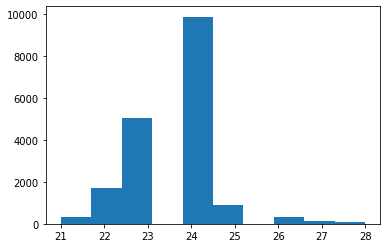

In [78]:
plt.hist(activity_score_df['sgRNA length (including PAM)'])

# Nucleotides at each position.
# Featurized as numbers

In [102]:
max_len = max(activity_score_df['sgRNA sequence'].str.len())
sgRNA_seq = activity_score_df['sgRNA sequence'].str.split('', expand=True)
sgRNA_seq['Length'] = activity_score_df['sgRNA sequence'].str.len()
# drop blank columns containing all empty strings
sgRNA_seq.drop(columns = [0, 26],  inplace=True)
# replace empty strings with 'None'
sgRNA_seq.replace(to_replace='', value=None, inplace=True)
sgRNA_seq.head()

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,Length
0,G,C,G,C,T,C,T,G,A,T,...,G,A,G,C,G,,None,None,None,21
1,G,C,C,C,C,A,G,G,A,T,...,C,C,G,C,G,,None,None,None,21
2,G,G,C,C,G,C,C,C,T,C,...,C,T,C,T,G,,None,None,None,21
3,G,A,C,G,G,C,G,A,C,C,...,G,A,G,G,T,,None,None,None,21
4,G,G,T,G,C,A,G,C,G,G,...,G,G,C,G,G,,None,None,None,21


In [103]:
# Need numerical fetaures for ML. 
# Nucleotides at each position.
sgRNA_seq.replace(to_replace='A', value=0, inplace=True)
sgRNA_seq.replace(to_replace='C', value=1, inplace=True)
sgRNA_seq.replace(to_replace='G', value=2, inplace=True)
sgRNA_seq.replace(to_replace='T', value=3, inplace=True)
sgRNA_seq.head()

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,Length
0,2,1,2,1,3,1,3,2,0,3,...,2,0,2,1,2,,None,None,None,21
1,2,1,1,1,1,0,2,2,0,3,...,1,1,2,1,2,,None,None,None,21
2,2,2,1,1,2,1,1,1,3,1,...,1,3,1,3,2,,None,None,None,21
3,2,0,1,2,2,1,2,0,1,1,...,2,0,2,2,3,,None,None,None,21
4,2,2,3,2,1,0,2,1,2,2,...,2,2,1,2,2,,None,None,None,21


# Overall nucleotide composition.

In [105]:
As = []
Cs = []
Gs = []
Ts = []
for index, row in sgRNA_seq.iterrows():
    As.append(sum(row == 0)/row['Length'])
    Cs.append(sum(row == 1)/row['Length'])
    Gs.append(sum(row == 2)/row['Length'])
    Ts.append(sum(row == 3)/row['Length'])
sgRNA_seq['As'] = As
sgRNA_seq['Cs'] = Cs
sgRNA_seq['Gs'] = Gs
sgRNA_seq['Ts'] = Ts
sgRNA_seq.head()

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,Length,As,Cs,Gs,Ts
0,2,1,2,1,3,1,3,2,0,3,...,2,,None,None,None,21,0.142857,0.238095,0.428571,0.238095
1,2,1,1,1,1,0,2,2,0,3,...,2,,None,None,None,21,0.142857,0.523810,0.333333,0.095238
2,2,2,1,1,2,1,1,1,3,1,...,2,,None,None,None,21,0.095238,0.380952,0.428571,0.190476
3,2,0,1,2,2,1,2,0,1,1,...,3,,None,None,None,21,0.238095,0.238095,0.476190,0.095238
4,2,2,3,2,1,0,2,1,2,2,...,2,,None,None,None,21,0.047619,0.333333,0.523810,0.190476


(array([2.516e+03, 3.359e+03, 5.327e+03, 4.537e+03, 1.651e+03, 7.380e+02,
        1.760e+02, 6.100e+01, 1.000e+01, 5.000e+00]),
 array([0.        , 0.07368421, 0.14736842, 0.22105263, 0.29473684,
        0.36842105, 0.44210526, 0.51578947, 0.58947368, 0.66315789,
        0.73684211]),
 <a list of 10 Patch objects>)

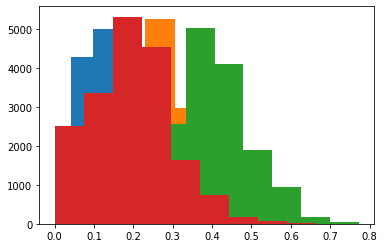

In [142]:
# Look at nucleotide distribution
plt.hist(sgRNA_seq['As'])
plt.hist(sgRNA_seq['Cs'])
plt.hist(sgRNA_seq['Gs'])
plt.hist(sgRNA_seq['Ts'])

# Nucleotide Dimers

In [115]:
def break_seq(seq):
    return [char for char in seq]

def break_seq_dimer(seq):
    return [seq[i:i+2] for i in range(0, len(seq)-1)]

In [116]:
# pd.DataFrame(activity_score_df['sgRNA sequence'].apply(break_seq))
pd.DataFrame(activity_score_df['sgRNA sequence'].apply(break_seq).tolist())

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,G,C,G,C,T,C,T,G,A,T,...,G,G,A,G,C,G,None,None,None,None
1,G,C,C,C,C,A,G,G,A,T,...,C,C,C,G,C,G,None,None,None,None
2,G,G,C,C,G,C,C,C,T,C,...,G,C,T,C,T,G,None,None,None,None
3,G,A,C,G,G,C,G,A,C,C,...,A,G,A,G,G,T,None,None,None,None
4,G,G,T,G,C,A,G,C,G,G,...,T,G,G,C,G,G,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18375,G,T,A,A,T,C,T,T,A,G,...,G,T,G,G,G,A,None,None,None,None
18376,G,T,G,A,C,T,T,C,A,A,...,T,C,T,T,A,None,None,None,None,None
18377,G,T,G,G,A,T,G,T,G,G,...,G,G,C,G,A,A,None,None,None,None
18378,G,A,C,A,C,C,T,C,A,G,...,T,A,A,G,A,C,None,None,None,None


In [139]:
# Nucleotide dimers
encodings = {'AA' : 0, 'AC' : 1, 'AG' : 2, 'AT' : 3, 'CA' : 4, 'CC' : 5, 'CG' : 6, 'CT' : 7, 
             'GA' : 8, 'GC' : 9, 'GG' : 10, 'GT' : 11, 'TA' : 12, 'TC' : 13, 'TG' : 14, 'TT' : 15}
sgRNA_dimers = pd.DataFrame(activity_score_df['sgRNA sequence'].apply(break_seq_dimer).tolist())

for dimer, repl in encodings.items():
    sgRNA_dimers.replace(dimer, repl, inplace = True)
    
sgRNA_dimers.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,9,6,9,7,13,7,14,8,3,15,...,6,10,8,2,9,6,None,None,None,None
1,9,5,5,5,4,2,10,8,3,13,...,5,5,5,6,9,6,None,None,None,None
2,10,9,5,6,9,5,5,7,13,6,...,2,9,7,13,7,14,None,None,None,None
3,8,1,6,10,9,6,8,1,5,5,...,8,2,8,2,10,11,None,None,None,None
4,10,11,14,9,4,2,9,6,10,10,...,15,14,10,9,6,10,None,None,None,None


# Overall dimer composition.

In [141]:
# Relevant dimers that the paper decsribes: GC, CA, AG
GC = []
CA = []
AG = []
for index, row in sgRNA_seq.iterrows():
    GC.append(sum(row == encodings['GC']))
    CA.append(sum(row == encodings['CA']))
    AG.append(sum(row == encodings['AG']))

sgRNA_dimers['GC'] = GC
sgRNA_dimers['CA'] = CA
sgRNA_dimers['AG'] = AG
              
sgRNA_dimers.head()             

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,GC,CA,AG
0,9,6,9,7,13,7,14,8,3,15,...,2,9,6,None,None,None,None,0,0,9
1,9,5,5,5,4,2,10,8,3,13,...,6,9,6,None,None,None,None,0,0,7
2,10,9,5,6,9,5,5,7,13,6,...,13,7,14,None,None,None,None,0,0,8
3,8,1,6,10,9,6,8,1,5,5,...,2,10,11,None,None,None,None,0,0,9
4,10,11,14,9,4,2,9,6,10,10,...,9,6,10,None,None,None,None,0,0,11


(array([ 715.,  615., 2982., 2560., 5830., 2419., 2607.,  441.,  199.,
          12.]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <a list of 10 Patch objects>)

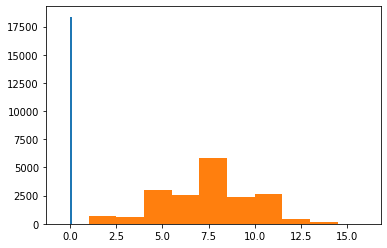

In [147]:
# See distribution
# plt.hist(sgRNA_dimers['GC'])
# plt.hist(sgRNA_dimers['CA'])
# plt.hist(sgRNA_dimers['AG'])

for the TSS info, copy thsat over for all 20 rows from the same gene
gene1 TSS
gene1 TSS
gene1 TSS 

In [197]:
genes = activity_score_df['gene symbol'].unique()
genes
len(genes)

1539

In [188]:
genes_tss = tss_annotation_df['gene'].tolist()

0     A1BG
1     A1BG
2     A1CF
3      A2M
4    A2ML1
Name: gene, dtype: object

In [204]:
dup_genes_tss = tss_annotation_df['gene'][tss_annotation_df['gene'].duplicated()].unique()

In [205]:
sum(np.isin(genes, dup_genes_tss))

75

In [207]:
genes[np.isin(genes, dup_genes_tss)]

array(['ATP5A1', 'ATP5J2-PTCD1', 'BCL2L1', 'BOD1L1', 'C11orf45', 'CANX',
       'CBFA2T3', 'CCNK', 'CDK6', 'CENPA', 'CKAP5', 'COPS7B', 'COPZ1',
       'DDX46', 'DDX54', 'DHODH', 'DNASE1L1', 'DPH1', 'DYNLRB1', 'EEF2',
       'EIF4G2', 'ESF1', 'FBXO8', 'FDFT1', 'FIS1', 'FOLR3', 'GON4L',
       'HAUS7', 'HMG20B', 'IDH3A', 'IFT74', 'IK', 'IL11RA', 'KMT2B',
       'LDB1', 'LSM5', 'MAPKAP1', 'MRPL30', 'MTHFD2', 'NDUFC1', 'NDUFS5',
       'NDUFV1', 'OAZ3', 'PKM', 'PMPCB', 'PNISR', 'POLR1D', 'POLR2D',
       'PPP2R1A', 'PRMT5', 'PSMB6', 'PSPH', 'PTCD1', 'RAB5C', 'RBM4',
       'RPS29', 'RSL1D1', 'SEC61A1', 'SF3A1', 'SLC12A9', 'SLC1A5', 'SNW1',
       'ST3GAL2', 'STAG2', 'TACC3', 'TAL1', 'TKT', 'TUBB', 'UBA1',
       'USP39', 'WBP11', 'ZMAT2', 'ZMYM3', 'ZNF574', 'ZNF699'],
      dtype=object)

In [202]:
genes_tss = tss_annotation_df['gene'].unique()
sum(np.logical_not(np.isin(genes, genes_tss)))

1

In [203]:
genes[np.logical_not(np.isin(genes, genes_tss))]

array(['NIFK'], dtype=object)

Note: the NIFK gene is not in the TSS data. For now, we simply removed this gene from our analysis, but may explore this more later. 

We are also checking if any of the entires in the activity_df are of duplicated genes in the TSS annotation (in which case transcript is required to specify which one). For now, we also removed the 75 which were duplicated, and we hope to revisit this. 